# Deep Learning Inverse Kinematic

In diesem Notebook erhalten Sie einen Einblick in das Thema Deep Learning mit PyTorch. Sie werden lernen, wie Sie mit tiefen neuronalen Netzen die Rückwärtstransformation für, beispielsweise, den YouBot von KUKA lösen können. Dabei werden Sie erfahren, wie man ein solches Netz mit PyTorch erstellt und trainiert.

Hilfreiche Links:

- Inverse Recurrent Models - An Application Scenario for Many-Joint Robot Arm Control: https://uni-tuebingen.de/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/informatik/lehrstuehle/kognitive-systeme/projects/inverse-kinematics-with-recurrent-neural-networks/
- Neural Network based Inverse Kinematics Solution for Trajectory Tracking of a Robotic Arm: https://www.sciencedirect.com/science/article/pii/S2212017313006361
- Applying Neural Network to Inverse Kinematic Problem for 6R Robot Manipulator with Offset Wrist: https://www.researchgate.net/publication/227064632_Applying_Neural_Network_to_Inverse_Kinematic_Problem_for_6R_Robot_Manipulator_with_Offset_Wrist
- A Neural Network Approach for Inverse Kinematic of a SCARA Manipulator: https://www.researchgate.net/publication/259198964_A_Neural_Network_Approach_for_Inverse_Kinematic_of_a_SCARA_Manipulator
- PyTorch Doc: https://pytorch.org/docs/stable/index.html

## Idee

Wir möchten die Rückwärtstransformation für einen Roboter, z.b. den YouBot, durchführen. Dies bedeutet, dass wir die Gelenkwinkel bestimmen müssen, die der Roboter einstellen muss, um einen vorgegebenen Punkt im Raum zu erreichen. Daraus ergeben sich die Eingabe- und Ausgabedaten des neuronalen Netzes, das wir erstellen werden. Das Netz erhält die Position des TCP (Tool Center Point) als Eingabeschicht und gibt am Ende die Gelenkwinkelstellungen aus.

## Vorbereitung der Daten

Einer der wichtigsten Aspekte beim Supervised Learning sind die Daten. In unserem Fall können wir diese Daten einfach erzeugen. Da uns die Vorwärtstransformation bekannt ist, können wir für beliebig viele Gelenkwinkelstellungen den TCP (Tool Center Point) berechnen.

#### DH-Parametertabelle youBot

$\begin{array}{rr} \hline
\mathbf{Gelenk} &\mathbf{\theta} &\mathbf{d} &\mathbf{a} &\mathbf{\alpha} \\ \hline
\mathbf{1} &0        &0.075 &0.033 &-\pi / 2 \\ \hline
\mathbf{2} &-\pi / 2 &0     &0.155 &0 \\ \hline
\mathbf{3} &0        &0     &0.135 &0 \\ \hline
\mathbf{4} &\pi / 2  &0     &0     &\pi / 2 \\ \hline
\mathbf{5} &\pi / 2  &0.218 &0     &0 \\ \hline
\end{array}$

Für die Vorwärtstransformation werden die DH-Parameter des YouBots benötigt die wir im folgenden Codebeispiel als numpy Arrays anlegen.

```python
import numpy as np

dh_theta_values = np.array([0, -np.pi / 2, 0, np.pi / 2, np.pi / 2])
dh_alpha_values = np.array([-np.pi / 2, 0, 0, np.pi / 2, 0])
dh_a_values = np.array([0.033, 0.155, 0.135, 0, 0])
dh_d_values = np.array([0.075, 0, 0, 0, 0.218])
```

Wir programmieren nun eine Python-Funktion <b>dhIthFrame</b> zur Erstellung eines einzelnen DH-Frames. Als Parameter werden $\theta$, $d$, $a$ und $\alpha$ des entsprechenden Gelenkes angenommen.

```python
def dhIthFrame(theta, d, a, alpha):
    
    rot_theta = np.matrix([ [np.cos(theta), -np.sin(theta), 0, 0], 
                            [np.sin(theta), np.cos(theta), 0, 0], [0, 0, 1, 0], 
                            [0, 0, 0, 1] ])
    
    trans_d = np.matrix([ [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, d], [0, 0, 0, 1] ])
    trans_a = np.matrix([ [1, 0, 0, a], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1] ])
    
    rot_alpha = np.matrix([ [1, 0, 0, 0], 
                            [0, np.cos(alpha), -np.sin(alpha), 0], 
                            [0, np.sin(alpha), np.cos(alpha), 0], [0, 0, 0, 1] ])
    
    dh_ith_frame = rot_theta * trans_d * trans_a * rot_alpha
    
    return dh_ith_frame
```

Dieses DH-Frame ist unsere Blaupause für die Forwärtstransformation am youBot. Wir definieren eine Python-Funktion <b>buildDhTcpFrame</b>, in welcher wir die Argumente eines solchen DH-Frames durch die DH-Parameterfür die Gelenkwinkel $a_{1}$ bis $a_{5}$ einsetzen und die resultierenden Frames zu einem Ergebnis-Frame akkumulieren.

```python
def buildDhTcpFrame(q_array):
    dh_frame = np.identity(4)
      
    for i in range(5):
        tmp_dh_ith = dhIthFrame(q_array[i] + dh_theta_values[i], 
                                dh_d_values[i], 
                                dh_a_values[i], 
                                dh_alpha_values[i])
        dh_frame = np.matmul(dh_frame, tmp_dh_ith)
    
    return dh_frame
```

Mit dieser Funktion haben wir nun die Möglichkeit TCP und Ausrichtung für übergebene Gelenkwinkelstellungen auszurechnen. Für die Erzeugung unseres Datensatzes brauchen wir nur noch die Anzahl an Gelenkwinkelstellungen.
Dazu beachten wir die Gelenkwinkelgrezen jedes Gelenks am YouBot.

$\begin{array}{rr} \hline
\mathbf{Gelenk} &{Grenzen°} &{Grenzen°} \\ \hline
\mathbf{A1} &-169°        &169°  \\ \hline
\mathbf{A2} &-65°         &90°  \\ \hline
\mathbf{A3} &-150°        &146°   \\ \hline
\mathbf{A4} &-102.5°      &102.5°   \\ \hline
\mathbf{A5} &-167.5°      &167.5° \\ \hline
\end{array}$

Es gibt viele denkbare Möglichkeiten, diese Gelenkwinkel zu generieren, aber dies soll nicht Teil dieses Notebooks sein. Um das Notebook übersichtlich zu halten, wurden einige Funktionen ausgelagert. Ein naiver Ansatz wäre beispielsweise das zufällige Generieren von Gelenkwinkeln. Ein kurzes Code-Snippet, wie es in der Klasse zu finden ist, als Beispiel:
```python
for joint_range in joint_limits:
    joint_val = np.random.randint(joint_range[1], joint_range[0] + 1)
    degree_joint_pos.append(joint_val)
degree_joint_pos = np.asarray(degree_joint_pos)
radians = np.radians(degree_joint_pos)     
```

Die einzelnen Gelenkwinkelgrenzen werden in einer Liste abgespeichert, und es wird ein zufälliger Wert innerhalb dieser Grenzen gezogen und in eine weitere Liste gespeichert. Die Werte in Grad werden zum Schluss in Bogenmaß umgerechnet.

Für die Generierung der Daten wird die Klasse DataHandler bereitgestellt. Zur Initialisierung dieser Klasse wird ein Roboter benötigt. Sie können neben dem YouBot (youbot) auch einen generischen Zweiachsenmanipulator (twoaxis) oder einen Baxterarm (baxter) übergeben. Wenn Sie in die Robot-Klasse hineinschauen, werden Sie feststellen, dass Sie auch eigene Roboter definieren können, indem Sie die DH-Parameter übergeben. Die DataHandler-Klasse benötigt keine weiteren Parameter zur Erstellung.

In [1]:
from src.datahandler import DataHandler
from src.robot import Robot

datahandler = DataHandler(robot=Robot(robot='twoaxis'))

Zum Test erzeugen wir 100 Gelenkwinkelpositionen und die dazugehörigen TCP Frames.

In [2]:
tcp, pos = datahandler(1000, normalize=False)

Die Dimension der generierten Daten kann man sich über die shape Funktion von numpy anzeigen lassen. Wir sehen dass wir für unser Netz eine Eingangsgröße von 12 Punkten haben, diese ergibt sich aus der Matrix des TCP, dabei wird die untere Reihe bewusst unterschlagen, da sie immer aus [0,0,0,1] besteht. Als Ausgang des Netzes haben wir die gewünschten 5 Gelenkwinkelpositionen.

In [3]:
print("TCP Shape:", tcp.shape)
print("Joint Shape:", pos.shape)

TCP Shape: (1000, 12)
Joint Shape: (1000, 2)


Nun können wir uns noch einige der TCP Frames anzeigen lassen und überprüfen ob sie richtig erzeugt wurden.

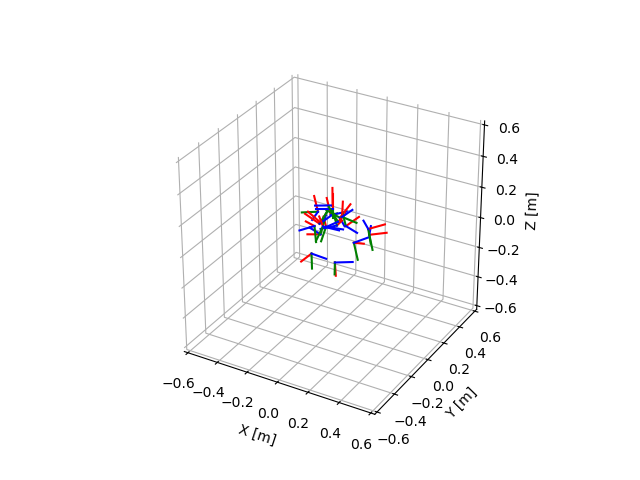

In [4]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.rotations import plot_basis
from pytransform3d.plot_utils import make_3d_axis

# Konstanten
AXIS_SCALE = 0.6
SAMPLE_SIZE = 20
POINT_SCALE = 1

fig = plt.figure()
ax = make_3d_axis(ax_s=AXIS_SCALE, unit="m", n_ticks=6)

samples = np.random.randint(0, len(tcp), SAMPLE_SIZE)
for i in samples:
    point = tcp[i][3::4] * POINT_SCALE
    rot = np.asarray([tcp[i][0:3], tcp[i][4:7], tcp[i][8:11]])
    plot_basis(ax, R=rot, p=point, s=0.1)

plt.show()

Mit der `probplot` Funktion von scipy können wir überprüfen ob die generierten Werte des Datahandlers einer Gleichverteilung folgen, dazu erstellt diese Funktion ein Wahrscheinlichkeitsdiagramm.

Ein Wahrscheinlichkeitsdiagramm ist ein grafisches Werkzeug zur Beurteilung, ob eine Datensatzverteilung einer theoretischen Verteilung folgt. Es tut dies, indem es die geordneten Datenwerte gegen die erwarteten Werte der entsprechenden Quantile der gewählten theoretischen Verteilung aufträgt. Wenn die Daten der theoretischen Verteilung folgen, sollten die Punkte im Diagramm ungefähr entlang einer geraden Linie liegen.

Sie werden sehen, dass dies bei 100 Werten nicht der Fall ist, sich mit steigendem `n` aber immer weiter der Linie annähert.

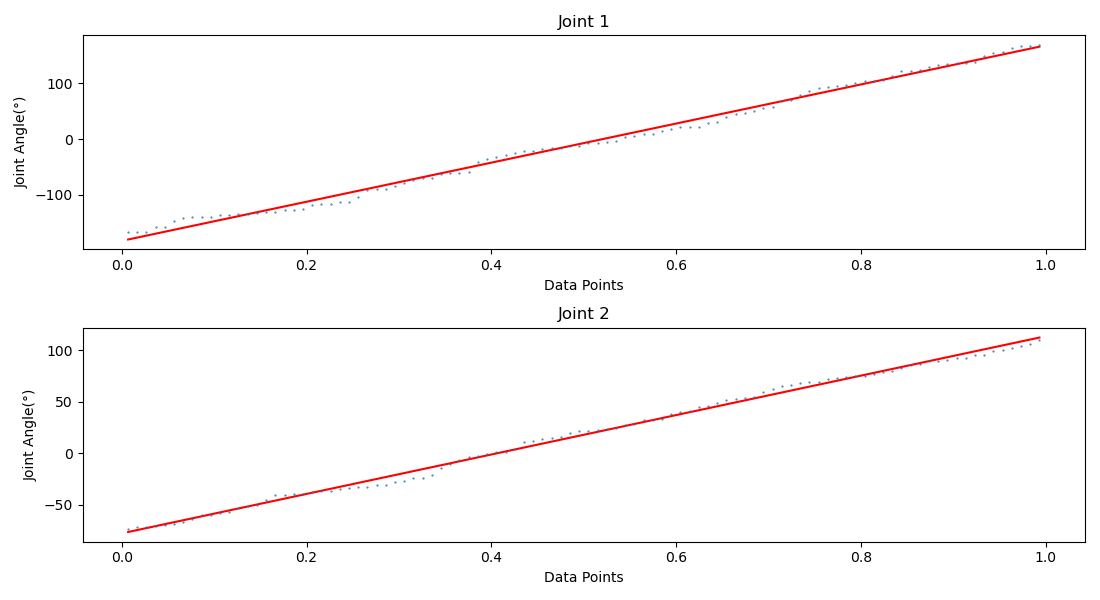

In [5]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

n_pos = datahandler.generate_n_positions(n=100)
n_joints = n_pos.shape[1]

n_cols = int(np.ceil(np.sqrt(n_joints)))
n_rows = int(np.ceil(n_joints / n_cols))

fig, axs = plt.subplots(n_cols, n_rows, figsize=(11, 6))
    
axs = axs.flatten()

# remove the extra subplots
for i in range(n_joints, n_rows * n_cols):
    fig.delaxes(axs[i])

for i in range(n_joints):
    (osm, osr), (slope, intercept, r) = stats.probplot(n_pos[:, i], dist="uniform")
    axs[i].plot(osm, slope*osm + intercept, 'r-', markersize=1)    
    axs[i].plot(osm, osr, 'o', markersize=0.5)  # Adjust the markersize here
    axs[i].set_title(f'Joint {i+1}')
    axs[i].set_xlabel('Data Points')
    axs[i].set_ylabel('Joint Angle(°)')
    


plt.tight_layout()
plt.show()

Wenn wir alles richtig gemacht haben, ist unser Datengenerator fertig und liefert uns sowohl die Eingabe- als auch die Ausgabedaten für das neuronale Netz. Für das Training mit Supervised Learning benötigen wir beides. Die Eingabedaten (TCP) werden durch das Netz propagiert, welches eine Ausgabe (Gelenkwinkelstellung) liefert. Diese Ausgabe wird mit den erwarteten Gelenkwinkelstellungen für den TCP verglichen, und ein Fehler wird berechnet. Anhand dieses Fehlers kann das Netz seine Gewichte über den Backpropagation-Algorithmus anpassen.

Um es dem Netz zu erleichtern, wird die Rotationsmatrix des TCP in die speziellen Eulerwinkel roll, pitch und yaw umgewandelt. Dies wird ebenfalls von der DataHandler-Klasse übernommen, indem der Parameter euler=True gesetzt wird. Möchte man wieder mit den ursprünglichen TCP-Daten arbeiten, setzt man diesen Parameter auf False. Der DataHandler benötigt auch Informationen, ob der relative TCP berechnet werden soll und ob mit verrauschten Gelenkwinkeln gearbeitet werden soll, um die Form des Netzwerkeingangs zu berechnen.

Beispielsweise können Sie die Ausgabe von TCP + Rotationsmatrix in XYZ-Positionen und Eulerwinkel umwandeln, wodurch sich die Form der Daten von 12 auf 6 ändert:
```python
datahandler.euler = True
```

Wenn Sie die Datengenerierung ändern möchten, sodass die Ausgabe aus (tcp, joint_pos) zu (tcp, joint_pos, noised_tcp, noised_joint_positions) wechselt, können Sie dies tun, indem Sie die Parameter entsprechend setzen. Die Form der Daten ändert sich dabei abhängig davon, ob Eulerwinkel genutzt werden, von 12/6 zu 29/17:

```python
datahandler.relative = True
datahandler.noised = True
```

In [6]:
datahandler.euler = False
datahandler.relative = False
datahandler.noised = False

Nun sollten wir uns im Vorfeld Gedanken darüber machen, wie unser Netz aussehen sollte. Neben dem Input- und dem Output-Layer haben wir noch eine Anzahl an sogenannten Hidden-Layers. Die Anzahl der Units im Input- und Output-Layer ist klar definiert, aber im Hidden-Layer können beliebig viele Neuronen mit diesen Schichten verbunden werden.

Wir benutzen PyTorch, um das Netz aufzubauen. Da es sich um ein einfaches Feed-Forward-Netz handelt, verwenden wir die Sequential()-Klasse von PyTorch, um das Modell zu erstellen. Diesem Modell können nun Layer hinzugefügt werden, analog zu unseren vorherigen Überlegungen. Ein Fully Connected Layer kann über die Klasse Linear() erstellt werden, wobei wir die Inputdimension (*in_features*), die Ausgangsdimension (*out_features*) und die Aktivierungsfunktion definieren. Diese Layer können über <code>add_module</code> dem Modell hinzugefügt werden. So kann man das Netz sehr einfach von vorne nach hinten aufbauen.

Der folgende Code zeigt, wie das Modell in PyTorch definiert wird:

In [7]:
import torch
import torch.nn as nn

class IK_Solver(nn.Module):
    def __init__(self, euler=False):
        super(IK_Solver, self).__init__()

        in_features = datahandler.get_input_shape()
        out_features = datahandler.get_output_shape()
        
        neurons = 512
        self.layers = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=neurons, bias=False),
            nn.BatchNorm1d(neurons),
            nn.ReLU()
        )
        
        hidden_layers = 2
        for i in range(hidden_layers):
            self.layers.add_module('hidden_layer_' + str(i), nn.Linear(neurons, neurons))
            self.layers.add_module('batch_norm_' + str(i), nn.BatchNorm1d(neurons))
            self.layers.add_module('activation_' + str(i), nn.ReLU())
            self.layers.add_module('dropout_' + str(i), nn.Dropout(0.3))
        
        self.layers.add_module('output_layer', nn.Linear(neurons, out_features, bias=False))
        self.layers.add_module('output_activation', nn.Tanh())
    
    def forward(self, x):
        return self.layers(x)

# Instantiate the model
model = IK_Solver()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In diesem Beispiel wird die Klasse IK_Solver definiert. Im Konstruktor (__init__) wird das Netzwerk erstellt. Zunächst werden die Eingabedimension (in_features) und die Ausgabedimension (out_features) basierend auf dem DataHandler ermittelt.

Das Netzwerk beginnt mit einem Fully Connected Layer (nn.Linear), gefolgt von einer Batch-Normalisierung (nn.BatchNorm1d) und einer ReLU-Aktivierungsfunktion (nn.ReLU).

Wir fügen dann zwei versteckte Schichten (Hidden Layers) hinzu, die jeweils aus einem Fully Connected Layer, einer Batch-Normalisierung, einer ReLU-Aktivierungsfunktion und einem Dropout (nn.Dropout) bestehen.

Abschließend wird ein Ausgabelayer (output_layer) hinzugefügt, der die Ausgabe des Netzwerks liefert. Eine Tanh-Aktivierungsfunktion wird verwendet, um die Ausgabe auf einen bestimmten Bereich zu beschränken.

Das Modell wird schließlich instanziiert und auf die verfügbare Hardware (CPU oder GPU) geladen.

Nun haben wir unsere Trainingsdaten und unser Netz, das trainiert werden soll. Bevor wir dieses trainieren können, muss der Lernprozess konfiguriert werden. Dazu müssen der Optimierer und die Loss-Funktion definiert werden.

Die Loss-Funktion bestimmt, wie der Fehler am Ausgang des Netzes berechnet wird, welcher minimiert werden soll. Der Optimierer ist für das Einstellen der Gewichte im Netz zuständig. In diesem Fall verwenden wir den Adam-Optimierer und den Mean Squared Error (MSE) als Loss-Funktion.

In [8]:
import torch.optim as optim
# For a mean squared error regression problem
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

model.to(device)
model.train() # Set the model to train mode
print(f"Using device: {device}")

Using device: cuda


Man kann sich das kompilierte Modell in einer Tabelle anzeigen lassen.

In [9]:
print(model)

IK_Solver(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=512, bias=False)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (hidden_layer_0): Linear(in_features=512, out_features=512, bias=True)
    (batch_norm_0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation_0): ReLU()
    (dropout_0): Dropout(p=0.3, inplace=False)
    (hidden_layer_1): Linear(in_features=512, out_features=512, bias=True)
    (batch_norm_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation_1): ReLU()
    (dropout_1): Dropout(p=0.3, inplace=False)
    (output_layer): Linear(in_features=512, out_features=2, bias=False)
    (output_activation): Tanh()
  )
)


PyTorch gibt es in einer CPU und einer GPU Variante. Wenn man sich nicht sicher ist welche gerade in diesem Notebook läuft kann man es sich vorher nochmal ausgeben lassen. 

In [10]:
print("PyTorch Version:", torch.__version__)
if torch.cuda.is_available():
    print("GPU is available")
    print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("GPU not available")

PyTorch Version: 2.3.1+cu121
GPU is available
Device name:  NVIDIA GeForce GTX 1050 Ti


Wenn Sie CUDA über Anaconda installiert haben müssen Sie eventuell die Datei `env-prefix/etc/conda/activate.d/env_vars.sh` anlegen:

``` bash
#!/bin/sh

export LD_LIBRARY_PATH="$CONDA_PREFIX/lib"
```

Nun können wir endlich unser Modell trainieren. Vorher erzeugen wir noch einen neuen Datensatz, da 100 Beispiele nicht ausreichen, um ein zufriedenstellendes Ergebnis zu erzielen. Es sollten pro Epoche mindestens 100.000 Datensätze erzeugt werden.

Um das Training zu starten, verwenden wir die <code>Trainer</code>-Klasse, die den Trainingsloop übernimmt und den Trainingsprozess vereinfacht. Diese Klasse kümmert sich um das Laden der Daten, das Training des Modells und die Validierung.

Hier ist der Code zur Initialisierung und zum Starten des Trainings:

```python
from src.trainer import Trainer

# Set DataHandler to torch, so it generates tensors
datahandler.set_torch(True)
trainer = Trainer(model, optimizer, criterion, device)
trainer.tcp_loss = False
trainer(datahandler, samples=250000, epochs=250, batch_size=1000)
model.eval()
```

In diesem Code wird der <code>DataHandler</code> so konfiguriert, dass er PyTorch-Tensoren generiert. Danach wird ein <code>Trainer</code>-Objekt erstellt und konfiguriert. Der Trainingsprozess wird gestartet, indem die <code>__call__</code>-Methode des <code>Trainer</code>-Objekts aufgerufen wird. Hierbei werden die benötigten Parameter wie die Anzahl der Beispiele (*samples*), die Anzahl der Epochen (*epochs*) und die Batch-Größe (*batch_size*) übergeben.

Die <code>Trainer</code>-Klasse führt folgende Schritte aus:

**Datenaufteilung und Laden:** Der Datensatz wird in Trainings- und Validierungsdaten aufgeteilt, und DataLoader werden erstellt.

**Trainingsschleife:** Für jede Epoche wird das Modell trainiert, indem Eingabedaten durch das Netz propagiert, der Fehler berechnet und die Gewichte aktualisiert werden.

**Validierung:** Nach jeder Epoche wird das Modell evaluiert, um den Validierungsfehler zu berechnen.

Während des Trainingsprozesses werden die aktuellen Trainings- und Validierungsverluste (*loss* und *val_loss*) ausgegeben. Der Trainingsverlust zeigt, wie gut das Modell die Trainingsdaten gelernt hat, während der Validierungsverlust anzeigt, wie gut das Modell auf unbekannte Daten generalisiert. Ein wesentlich kleinerer Trainingsverlust im Vergleich zum Validierungsverlust deutet auf Overfitting hin.


In [ ]:
from src.trainer import Trainer

# Set DataHandler to torch, so it generates tensors
datahandler.set_torch(True)
trainer = Trainer(model, optimizer, criterion, device)
trainer.tcp_loss = False
trainer(datahandler, samples=250000, epochs=5, batch_size=100)
model.eval()

Epoch 1/5: 100%|██████████████████████████████████████████████████| 2375/2375 [00:07<00:00, 305.58it/s, loss=0.00614]


Epoch 1/5, Train Loss: 0.0074, Val Loss: 0.0011


Epoch 2/5: 100%|██████████████████████████████████████████████████| 2375/2375 [00:07<00:00, 307.09it/s, loss=0.00265]


Epoch 2/5, Train Loss: 0.0030, Val Loss: 0.0006


Epoch 3/5: 100%|██████████████████████████████████████████████████| 2375/2375 [00:07<00:00, 313.64it/s, loss=0.00209]


Epoch 3/5, Train Loss: 0.0024, Val Loss: 0.0006


Epoch 4/5: 100%|██████████████████████████████████████████████████| 2375/2375 [00:07<00:00, 315.99it/s, loss=0.00262]


Epoch 4/5, Train Loss: 0.0023, Val Loss: 0.0005


Epoch 5/5: 100%|██████████████████████████████████████████████████| 2375/2375 [00:07<00:00, 309.97it/s, loss=0.00164]


Epoch 5/5, Train Loss: 0.0021, Val Loss: 0.0004


IK_Solver(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=512, bias=False)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (hidden_layer_0): Linear(in_features=512, out_features=512, bias=True)
    (batch_norm_0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation_0): ReLU()
    (dropout_0): Dropout(p=0.3, inplace=False)
    (hidden_layer_1): Linear(in_features=512, out_features=512, bias=True)
    (batch_norm_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation_1): ReLU()
    (dropout_1): Dropout(p=0.3, inplace=False)
    (output_layer): Linear(in_features=512, out_features=2, bias=False)
    (output_activation): Tanh()
  )
)

So trainierte Modelle können über die Funktionen <code>save()</code> und <code>load_weights()</code> gespeichert und geladen werden. Achten Sie darauf, dass das Modell vorher initialisiert sein muss, falls Sie an der Struktur des Netzes etwas ändern wird die Funktion <code>load_weights()</code> das Modell nicht mehr laden können.
```python
torch.save(model.state_dict(), 'model_IK_noised.pt')
model.load_state_dict(torch.load('model_IK_noised.pt'))
```

In [12]:
torch.save(model.state_dict(), 'model_IK.pt')

In [13]:
model.load_state_dict(torch.load('model_IK.pt'))
model.eval()

IK_Solver(
  (layers): Sequential(
    (0): Linear(in_features=14, out_features=1024, bias=False)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (hidden_layer_0): Linear(in_features=1024, out_features=1024, bias=True)
    (batch_norm_0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation_0): ReLU()
    (dropout_0): Dropout(p=0.3, inplace=False)
    (hidden_layer_1): Linear(in_features=1024, out_features=1024, bias=True)
    (batch_norm_1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation_1): ReLU()
    (dropout_1): Dropout(p=0.3, inplace=False)
    (hidden_layer_2): Linear(in_features=1024, out_features=1024, bias=True)
    (batch_norm_2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation_2): ReLU()
    (dropout_2): Dropout(p=0.3, inplace=False)
    (hidden_layer_3): Linear(in_feat

Nun wollen wir überprüfen ob unser Netz auch auf neuen Daten funktioniert. Dafür generieren wir uns wieder einige Daten. Die so generierten TCPs dienen wieder als Eingabe in unser Modell. Über die <code>__call__</code> Funktion können wir unsere Daten durch das Netz propagieren um eine Ausgabe zu erhalten. Was bislang verschwiegen wurde ist, dass die Daten bevor sie in das Netz gespeist wurden normalisiert waren, diese Normalisierung muss rückgängig gemacht werden, bevor wir weiter mit den Daten arbeiten können.

In [12]:
datahandler.compute_extreme_positions = False
datahandler.set_torch(True)
tcp, gt_joints = datahandler(2000)
pred = model(tcp)
# Denormalize joint positions and TCP and get it off the GPU and back to numpy arrays
gt_pos = datahandler.denorm_joint(gt_joints).cpu().numpy()
if trainer.tcp_loss:
    pred = datahandler.denorm_tcp(pred).cpu().detach().numpy()
else:
    pred = datahandler.denorm_joint(pred).cpu().detach().numpy()
datahandler.set_torch(False)
model.eval()
pass

Startpunkt ist immer [0,0,0....]

Wir können uns nun für einzelne Werte die Roboterstellungen für *Ground Truth* und *Prediction* der Gelenkwinkelstellungen anzeigen lassen. Orange bildet hierbei die *Ground Truth* ab und grün die *Prediction*, so bekommen wir eine grapfische Repräsentation von dem was unser Netz gelernt hat.

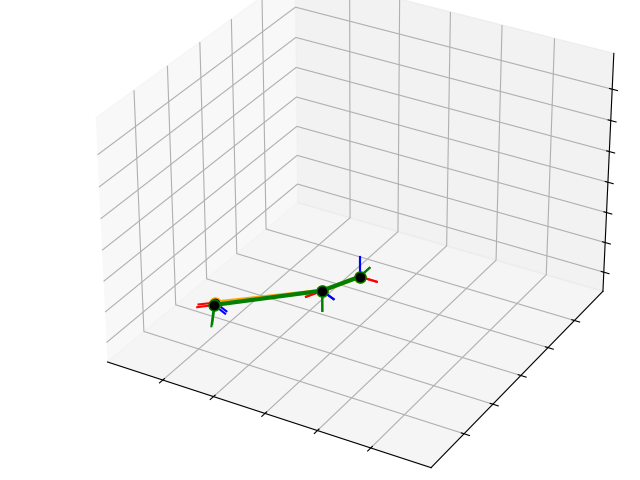

In [13]:
%matplotlib widget
from src.robot_animation import RobotAnimation

drawer = RobotAnimation(datahandler.robot)
#Nummer des Datensatzes
t = 91
drawer.draw_robot([gt_pos[t], pred[t]])

Um einen noch besseren Eindruck zu bekommen ob unser Netz gut arbeitet können wir Gelenkwinkelpositionen generieren die eine bestimmte Trajektorie abfahren. Wir lassen uns die Trajektorie mit matplotlib ausgeben, wenden die Vorwärtstransformation auf unsere so generierten Gelenkwinkel an um den TCP zu bekommen. Diesen geben wir in unser trainiertes Netz und für den so generierten Ausgangsvektor der Gelenkwinkel lassen wir erneut die Trajektorie abfahren.

Als erstes generieren wir einfachhalber einen Gelenkwinkelvektor als numpy array.

Ausgehend von unserem generierten Startwert können nun iterativ ausgewählte Werte des Vektors verändert werden um unterschiedliche Trajektorien abzufahren. Dabei sollte darauf geachtet werden die Gelenkwinkelgrenzen des YouBots einzuhalten.

In [86]:
#start = np.array([169, -50, -20, -30, 0])
start = np.array([169, 50])
arr = []
arr.append(start)
for i in range(52):
    start = np.copy(start)
    if(start[0]-6.5)>=datahandler.robot.joint_limits[0][1]:
        start[0] += -6
    arr.append(start)

arr = np.deg2rad(np.asarray(arr))

Der so erzeugte Gelenkwinkelvektor kann der Funktion <code>draw_trajectory()</code> der Drawer Klasse übergeben werden um mit matplotlib eine animierte Trajektorie anzuzeigen.

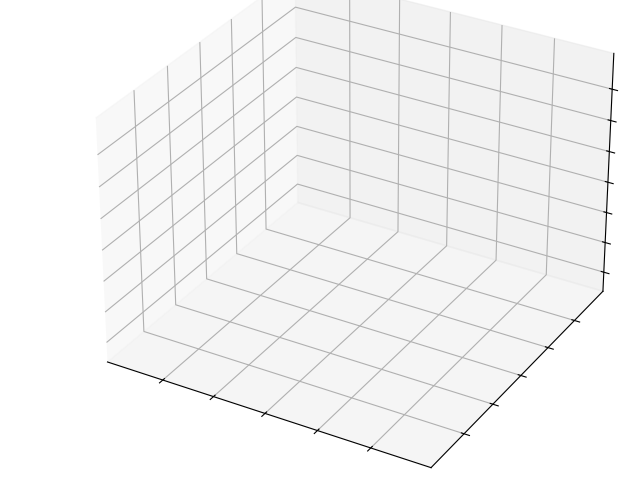

In [87]:
%matplotlib widget
    
drawer = RobotAnimation(robot=datahandler.robot)

drawer.draw_trajectory_robot(arr)

In [88]:
datahandler.set_torch(False)
arr_tcp = datahandler.get_tcp(arr)
arr_tcp = datahandler.norm_tcp(arr_tcp)

#Start positions and TCP
start_rad = np.array([arr[0]])
old_jpos = datahandler.norm_joint(start_rad)
old_tcp = arr_tcp[0]
    
old_jpos = old_jpos[0]
    
trajectory = []
trajectory.append(start_rad)
#trajectory.append(datahandler.denorm_joint(np.radians([old_jpos])))
for i, tcp in enumerate(arr_tcp):
    #delta_tcp = np.subtract(tcp, old_tcp)
    #input_ = np.expand_dims(np.concatenate((old_jpos, old_tcp, tcp)), axis=0)
    input_ = torch.tensor(tcp, dtype=torch.float32).to(device)
    input_jpos = torch.tensor(old_jpos, dtype=torch.float32).to(device)
    input_tcp = torch.tensor(old_tcp, dtype=torch.float32).to(device)
    if not datahandler.relative and not datahandler.noised:
        in_ = torch.unsqueeze(input_tcp, 0)
    else:
        in_ = torch.unsqueeze(torch.cat((input_jpos, input_tcp, input_)), 0)
    
    output = model(in_).cpu().detach().numpy()
    old_jpos = output[0]
    old_tcp = tcp
    trajectory.append(datahandler.denorm_joint(output))
trajectory = np.squeeze(trajectory, 1)

Zum Schluss können wir die so erzeugen Gelenkwinkelpositionen erneut als Trajektorie abfahren lassen und bekommen so ein visuellen Vergleich zwischen Soll und Ist.

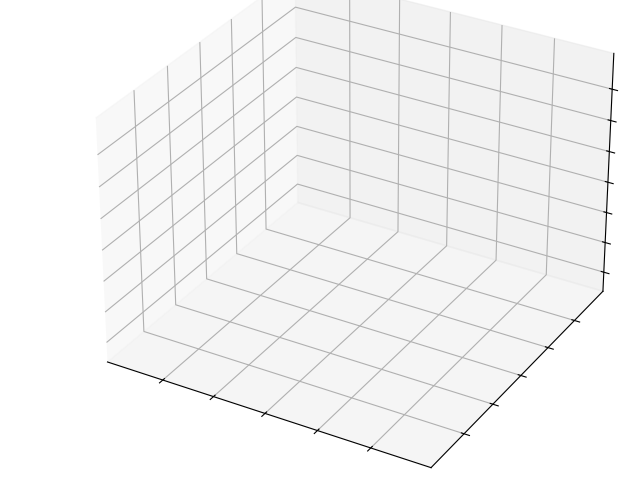

In [89]:
%matplotlib widget
drawer2 = RobotAnimation(robot=datahandler.robot)

drawer2.draw_trajectory_robot(trajectory)